<a href="https://colab.research.google.com/github/monindew/Pytorch_Study/blob/main/20240820.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np

from copy import deepcopy

In [9]:
train_rawdata = datasets.MNIST(root= 'dataset', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root= 'dataset', train=False, download=True, transform=transforms.ToTensor())
print("number of trainig data: ", len(train_rawdata))
print("number of test data: ", len(test_rawdata))

number of trainig data:  60000
number of test data:  10000


In [10]:
VALIDATION_RATE = 0.2
train_indices, val_indices, _, _ = train_test_split(range(len(train_rawdata)), train_rawdata.targets, stratify=train_rawdata.targets, test_size=VALIDATION_RATE)

In [11]:
train_dataset = Subset(train_rawdata, train_indices)
validation_dataset = Subset(train_rawdata, val_indices)

In [12]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

48000 12000 10000


In [13]:
minibatch_size = 128
train_batches = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
validation_batches = DataLoader(validation_dataset, batch_size=minibatch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

In [16]:
X_train, y_train = next(iter(train_batches))

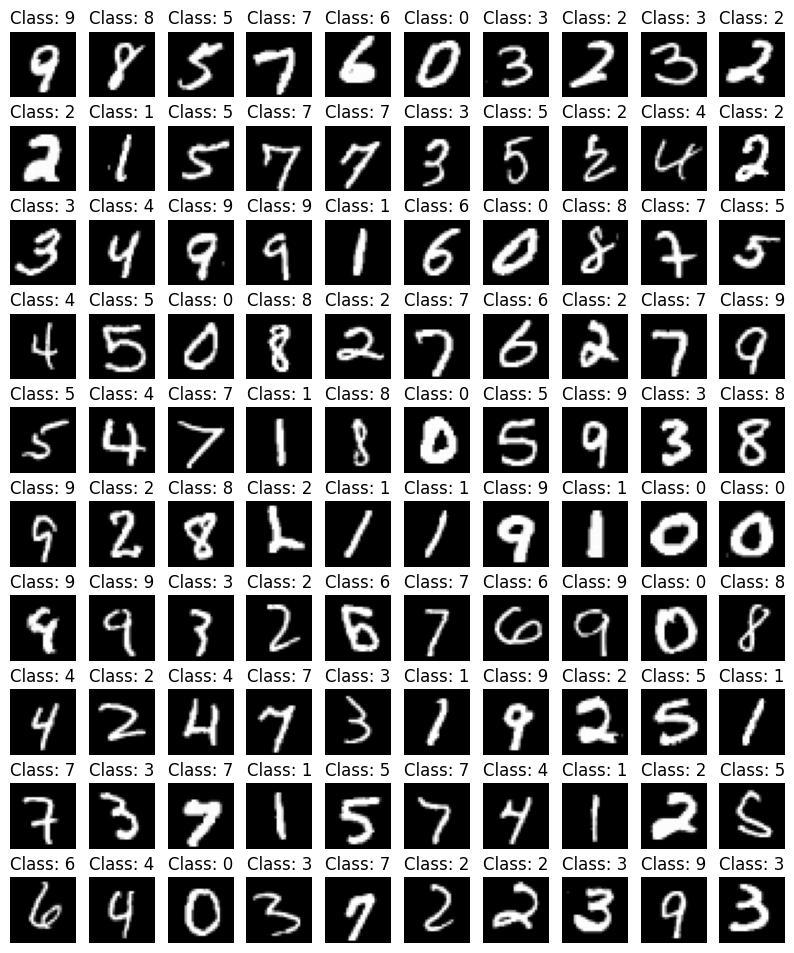

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 12))

for index in range(100):
  plt.subplot(10, 10, index + 1)
  plt.axis("off")
  plt.imshow(X_train[index, :, :, :].numpy().reshape(28, 28), cmap="gray")
  plt.title("Class: " + str(y_train[index].item()))

In [20]:
class layer(nn.Module):
  def __init__(self, input_size, output_size, batch_norm=True, dropout=0.5):
    self.input_size = input_size
    self.output_size = output_size
    self.batch_norm = batch_norm
    self.dropout = dropout

    super().__init__()

    self.layer = nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.LeakyReLU(),
        self.apply_regularization()
    )

  def apply_regularization(self):
    if self.batch_norm:
      return nn.BatchNorm1d(self.output_size)
    else:
      return nn.Dropout(self.dropout)

  def forward(self, x):
    return self.layer(x)

In [22]:
class DNNModel(nn.Module):
  def __init__(self, input_size, output_size, batch_norm=True, dropout=0.5):
    super().__init__()

    self.layers = nn.Sequential(
        layer(input_size, 256, batch_norm, dropout),
        layer(256, 256, batch_norm, dropout),
        layer(256, 128, batch_norm, dropout),
        nn.Linear(128, output_size),
        nn.LogSoftmax(dim=-1)
    )

  def forward(self, x):
    return self.layers(x)

In [23]:
input_size = 28 * 28
output_size = 10
model = DNNModel(input_size, output_size)
model

DNNModel(
  (layers): Sequential(
    (0): layer(
      (layer): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): layer(
      (layer): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): layer(
      (layer): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): LogSoftmax(dim=-1)
  )
)

In [24]:
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
def train_model(model, early_stop, n_epochs, progress_interval):
  train_losses, valid_losses, lowest_loss = list(), list(), np.inf

  for epoch in range(n_epochs):
    train_loss, valid_loss = 0, 0
    model.train()
    for x_minibatch, y_minibatch in train_batches:
      y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
      loss = loss_func(y_minibatch_pred, y_minibatch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss = train_loss / len(train_batches)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
      for x_minibatch, y_minibatch in validation_batches:
        y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
        loss = loss_func(y_minibatch_pred, y_minibatch)
        valid_loss += loss.item()

    valid_loss = valid_loss / len(validation_batches)
    valid_losses.append(valid_loss)

    if valid_losses[-1] < lowest_loss:
      lowest_loss = valid_losses[-1]
      lowest_epoch = epoch
      best_model = deepcopy(model.state_dict())
    else:
      if (early_stop > 0) and lowest_epoch + early_stop < epoch:
        print ("Early Stopped", epoch, "epochs")
        break

    if (epoch % progress_interval) == 0:
      print(train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)

  model.load_state_dict(best_model)
  return model, lowest_loss, train_losses, valid_losses

In [28]:
nb_epochs = 30
progress_interval = 3
early_stop = 10
model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.08528659345706303 0.11177874939080248 0.11177874939080248 0 0
0.03988501562178135 0.09716732454228591 0.09716732454228591 3 3
0.025057634911499916 0.09643734212310866 0.09107042799030055 5 6
0.016441157641199727 0.09592608277230187 0.09107042799030055 5 9
0.013462619695967685 0.09319113782298023 0.09107042799030055 5 12
0.008883240297591934 0.09627398359589279 0.09107042799030055 5 15
Early Stopped 16 epochs
